In [223]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import requests
from bs4 import BeautifulSoup
import folium
import json

Populating the interactive namespace from numpy and matplotlib


In [56]:
URL = 'http://www.patentsview.org/api/patents/query?'

The API cannot give more than 10000 patents at a time, we need to get the number of patents for every month and add them together

In [57]:
def get_nb_patents_month(month, year):
    #patent_date=date patent was granted
    if(month!='12'):
        query='q={"_and":[{"_gte":{"patent_date":"'+year+'-'+month+'-01"}},{"_lt":{"patent_date":"'+year+'-'+str(int(month)+1)+'-01"}}]}' 
    else:
        query='q={"_and":[{"_gte":{"patent_date":"'+year+'-'+month+'-01"}},{"_lt":{"patent_date":"'+str(int(year)+1)+'-01-01"}}]}'  
    r = requests.get(URL+query).json()
    return pd.DataFrame(r).total_patent_count[0]

    

In [58]:
def get_nb_patents_year(year):
    nb_patent=0
    for i in range(12):
        if i<10:
            nb_patent+=get_nb_patents_month('0'+str(i), year)
        else:
            nb_patent+=get_nb_patents_month(str(i), year)
    return nb_patent

In [59]:
year = list(range(2007,2017))
list_nb_patent=[get_nb_patents_year(str(i)) for i in year]
df_nb_patent=pd.DataFrame(index=year)
df_nb_patent['nb_patents']=list_nb_patent
df_nb_patent

,nb_patents
2007,183496
2008,181694
2009,190319
2010,245132
2011,246696
2012,275227
2013,296921
2014,326920
2015,324822
2016,340823


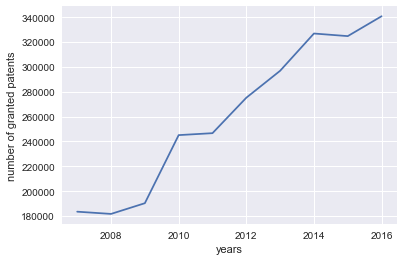

In [60]:
plot(year, df_nb_patent['nb_patents'])
plt.xlabel('years')
plt.ylabel('number of granted patents')
plt.show()

In [52]:
##NOT USEFUL ANYMORE
def get_countries():
    #patent_date=date patent was granted
    query='q={"_and":[{"_gte":{"patent_date":"2016-10-01"}},{"_lt":{"patent_date":"2017-01-01"}}]}' 
    output='&f=["inventor_country"]'
    option='&o={"page":1,"per_page":10}'
    r = requests.get(URL+query+output).json()  
    nb_patents= pd.DataFrame(r).total_patent_count[0]
    list_country_final=[]
    for i in range(int(nb_patents/50000)):
        option='&o={"page":'+str(i)+',"per_page":10000}'
        r = requests.get(URL+query+output).json()  
        df1=pd.DataFrame(r)
        list_inventors = list(map(lambda x: x['inventors'][0], df1.patents))
        list_inventors1  = list(set(map(lambda x: x['inventor_country'], list_inventors)))
        list_country_final = list(set(list_country_final + list_inventors1))       
    return list_country_final

In [180]:
dfLocation=pd.read_excel(os.getcwd()+'\\location.xlsx')

In [191]:
dfLocation.fillna(value='',inplace=True)
countries=list(set(list(dfLocation['country'])))
#just keep ISO country codes (remove error in the database)
countries = [countries[i] for i in range(len(countries)) if (len(countries[i]) == 2 and countries[i]!='a"')]

The function get_nb_patent_country return a number of patents for a given country. There are usually multiple inventor in a patent which can be in a different country. In that case, count +1 for a country if at least one of the inventor is in the given country. The function give a number of patent between january 2016 and january 2017

In [219]:
def get_nb_patent_country(country):
    query='q={"_and":[{"_gte":{"patent_date":"2016-01-01"}},{"_lt":{"patent_date":"2017-01-01"}},{"_eq":{"inventor_country":"'+country+'"}}]}' 
    output='&f=["inventor_country"]'
    option='&o={"matched_subentities_only":True}'
    r = requests.get(URL+query+output).json() 
    #print(r)
    try:
        nb_patents= pd.DataFrame(r).total_patent_count[0] 
    except ValueError:
        nb_patents=0
    
    return int(nb_patents)

In [220]:
dfNbPatents=pd.DataFrame(columns=['country','nb patents'])
dfNbPatents['country']=countries
dfNbPatents['nb patents']=list(map(lambda x: get_nb_patent_country(x),dfNbPatents['country']))

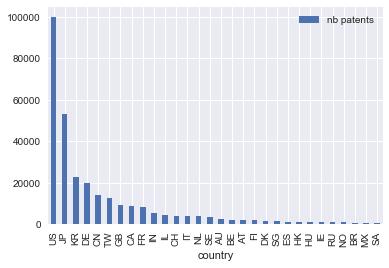

In [221]:
dfNbPatents.sort_values(by='nb patents',inplace=True, ascending=False)
dfNbPatents.head(30).plot.bar(x='country', y='nb patents')

In [231]:

m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=7)  
countries_geo_path = r'countries.json'
geo_json_data = json.load(open(countries_geo_path))

folium.GeoJson(geo_json_data).add_to(m)

#m.choropleth(geo_data=geo_json_data, data=dfNbPatents,
#             columns=['country', 'nb patents'],
#             key_on='feature.properties.ISO_A2',
#             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
#             legend_name='Number of patents granted')
m


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


3.6.1 |Anaconda custom (32-bit)| (default, May 11 2017, 14:16:49) [MSC v.1900 32 bit (Intel)]


True